## Plot data

In [1]:
import h5py
import numpy as np
import scipy as sp
import skimage as ski
import matplotlib.pyplot as plt
import os

from fusion import optimize
from utils import hyperspectral2RGB, hyperspectral2RGBvolume, bin_data
from utils import RESOURCES_PATH
from ipywidgets import interact

x = np.load(RESOURCES_PATH/"kidney"/"520_kidneyCells_550_550_610_SPC_raw_proc_tlxy_fused.npy")

LAMBDA_PATH = RESOURCES_PATH / "kidney" / "610_Lambda_L16.mat"

# SPC_PATH = RESOURCES_PATH / "kidney" / "520_kidneyCells_550_550_610_SPC_raw_proc_tlxy.mat"
DATA_RESOURCES_PATH = "/Users/federicosimoni/Library/Mobile Documents/com~apple~CloudDocs/Università/Tesi/Code/CS-FLIM_lab/20240703/kidney"
SPC_PATH = os.path.join(DATA_RESOURCES_PATH,"520_kidney2_550_550_610_SPC_raw_proc_tlxy.mat")

spc = sp.io.loadmat(SPC_PATH)["im"]
t = np.squeeze(sp.io.loadmat(SPC_PATH)["t"])
spc[:, :, 0, 0] = spc[:, :, 1, 0]

lam = np.squeeze(sp.io.loadmat(LAMBDA_PATH)["lambda"])

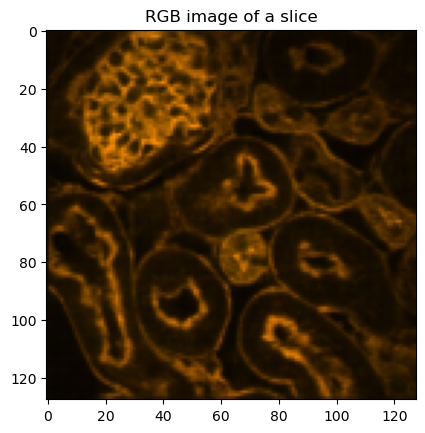

(26, 128)


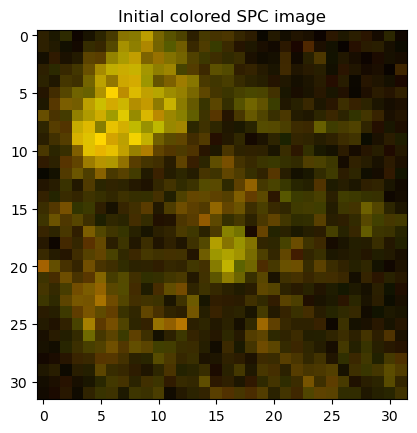

interactive(children=(IntSlider(value=9, description='index_z', max=26), Output()), _dom_classes=('widget-inte…

In [18]:
zxy = np.sum(x, axis=(0, 1))
zxy /= zxy.max()

t = range(x.shape[0])

# mdic = {"im": x[:,:,9,:,:]}
# sp.io.savemat("prova.mat", mdic)

slices_rgb = hyperspectral2RGBvolume(lam, np.mean(x, axis=0))
slice_rgb = hyperspectral2RGB(lam, np.mean(x, axis=0)[:,9,:,:])

plt.imshow(slice_rgb)
plt.title("RGB image of a slice")
plt.show()

means_spectrums = np.mean(x, axis=(0, 3, 4)).T
min_mean_spectrum = np.min(means_spectrums)
max_mean_spectrum = np.max(means_spectrums)

means_times = np.mean(x, axis=(1, 3, 4)).T
# print(means_times.shape)
min_mean_times = np.min(means_times)
max_mean_times = np.max(means_times)

plt.imshow(hyperspectral2RGB(lam, np.mean(spc, axis=0)))
plt.title("Initial colored SPC image")
plt.show()

def plot_across_z(index_z=9):
    _, ax = plt.subplots(2, 2, figsize=(8, 8))
    ax[0, 0].imshow(zxy[index_z], cmap="gray", vmin=0, vmax=1)
    ax[0, 0].set_title(f"Fused Image, z={index_z}")

    ax[0, 1].imshow(slices_rgb[index_z])
    ax[0, 1].set_title(f"Colored with spectrum")

    ax[1, 0].plot(lam, means_spectrums[index_z])
    ax[1, 0].set_ylim(min_mean_spectrum, max_mean_spectrum)
    ax[1, 0].set_title(f"Fused Spectrum, z={index_z}")

    ax[1, 1].plot(t, means_times[index_z])
    ax[1, 1].set_ylim(min_mean_times, max_mean_times)
    ax[1, 1].set_title(f"Fused Time, z={index_z}")

    plt.tight_layout()
    plt.show()


interact(plot_across_z, index_z=(0, len(zxy), 1));

In [3]:
reconstructed_spectrums = np.mean(x, axis=(0, 2))
reconstructed_times = np.mean(x, axis=(1, 2))

def spectrum_time_in_a_point(i=0, j=0):
    _, ax = plt.subplots(1, 3, figsize=(12, 4))
    z_index = np.argmax(means_spectrums.sum(axis=1))
    ax[0].imshow(slices_rgb[z_index])
    ax[0].scatter([j], [i], c="b")
    ax[0].set_title(f"Colored with spectrum")
    
    ax[1].plot(lam, reconstructed_spectrums[:, i, j])
    ax[1].set_title(f"Spectrum in ({i},{j})")
    
    ax[2].plot(t, reconstructed_times[:, i, j])
    ax[2].set_title(f"Time in ({i},{j})")
    plt.tight_layout()
    plt.show()
    
interact(spectrum_time_in_a_point, i=(0, x.shape[-2], 1), j=(0, x.shape[-1], 1));

interactive(children=(IntSlider(value=0, description='i', max=128), IntSlider(value=0, description='j', max=12…

In [4]:
slices_rgb[9][57, 58]
new_x = np.transpose(np.mean(x,axis=0)[:,9],(1,2,0))
new_x.shape

(128, 128, 16)

[547.35972343 556.56210764 565.76449186 574.96687608 584.1692603
 593.37164452 602.57402874 611.77641296 620.97879718 630.18118139
 639.38356561 648.58594983 657.78833405 666.99071827 676.19310249
 685.39548671]


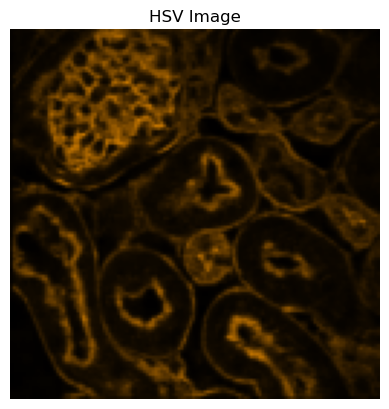

In [13]:
import cv2

print(lam)

def plot_hsv_image(tensor, wavelengths):
    """
    Plots the image from a 3D tensor (x, y, wavelengths) using HSV color space.
    
    :param tensor: 3D numpy array with shape (x, y, wavelengths)
    :param wavelengths: List of wavelengths corresponding to the third dimension of the tensor
    """
    # Ensure tensor is a numpy array
    tensor = np.array(tensor)
    
    # Map wavelengths to hue values (0 to 359 in OpenCV's HSV space)
    min_wav = min(lam)
    max_wav = max(lam)
    # wav_range = max_wav - min_wav
    min_hue = (min_wav-380)*359/400
    max_hue = (max_wav-380)*359/400
    num_wavelengths = len(wavelengths)
    hues = np.linspace(min_hue, max_hue, num_wavelengths)
    
    # Create an HSV image
    hsv_image = np.zeros((tensor.shape[0], tensor.shape[1], 3), dtype=np.uint8)
    
    for i in range(num_wavelengths):
        hue = hues[i]
        intensity = tensor[:, :, i]
        
        # Set hue
        hsv_image[:, :, 0] = hue
        
        # Set saturation to maximum (255)
        hsv_image[:, :, 1] = 255
        
        # Set value according to the normalized intensity
        hsv_image[:, :, 2] = (intensity * 255).astype(np.uint8)
    
    # Convert HSV to RGB for visualization
    rgb_image = cv2.cvtColor(hsv_image, cv2.COLOR_HSV2RGB)
    
    # Plot the image using matplotlib
    plt.imshow(rgb_image)
    plt.axis('off')
    plt.title('HSV Image')
    plt.show()

new_x = new_x/np.max(new_x)
plot_hsv_image(new_x, lam)


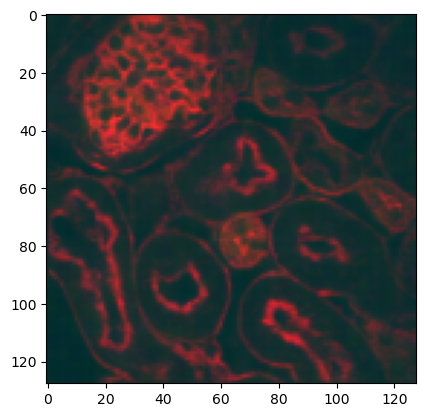

In [6]:
from sklearn.decomposition import PCA

new_x = new_x.reshape(-1,16)
new_x = (new_x - new_x.min()) / (new_x.max() - new_x.min())

pca = PCA(n_components=3)

result = pca.fit_transform(new_x)
result = result.reshape(128, 128, 3)

pca_image = (result - result.min()) / (result.max() - result.min()) * 255
pca_image = pca_image.astype(np.uint8)
plt.imshow(pca_image)

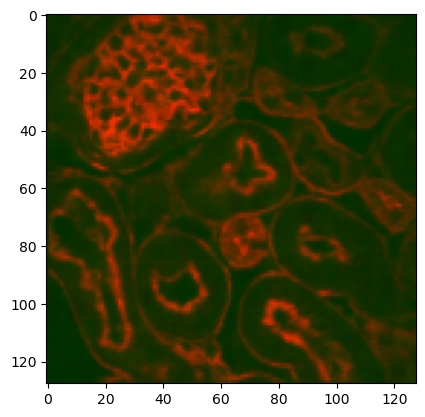

In [7]:
import copy
rgb = copy.deepcopy(pca_image)

rgb[:, :, 0] = pca_image[:, :, 0]
rgb[:, :, 1] = pca_image[:, :, 2]
rgb[:, :, 2] = 0
plt.imshow(rgb)

In [8]:
rgb[61, 68]

array([135,  46,   0], dtype=uint8)

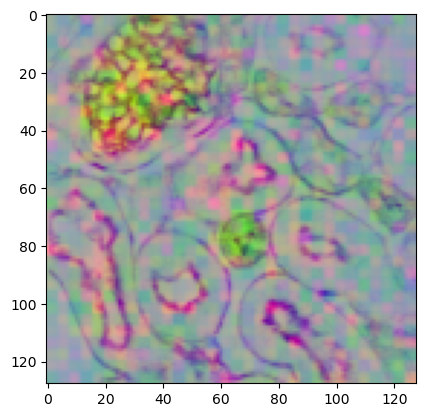

In [9]:
from sklearn.decomposition import FastICA

new_x = new_x.reshape(-1,16)
new_x = (new_x - new_x.min()) / (new_x.max() - new_x.min())

ica = FastICA(n_components=3, random_state=0)

result = ica.fit_transform(new_x)
result = result.reshape(128, 128, 3)

ica_image = (result - result.min()) / (result.max() - result.min()) * 255
ica_image = ica_image.astype(np.uint8)
plt.imshow(ica_image)

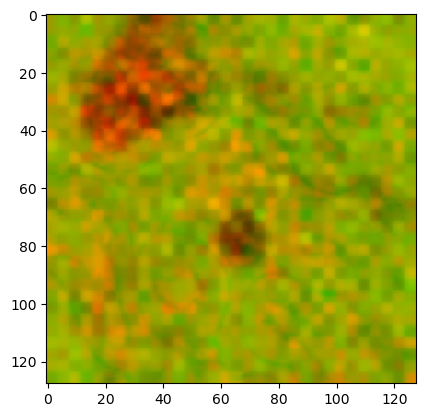

In [10]:
rgb = copy.deepcopy(pca_image)

rgb[:, :, 0] = ica_image[:, :, 0]
rgb[:, :, 1] = ica_image[:, :, 2]
rgb[:, :, 2] = 0
plt.imshow(rgb)